## EECS491 A4 E4
### Tristan Maidment (tdm47)

#### Goal
The purpose of this exercise is to combine what was learned in the GMM EM exercises with the low dimension repesentation of PCA.

As with the previous exercises, I will reduce redundancy only by explaining code not previously explained.

#### Implementation

In [1]:
%matplotlib inline 
import numpy as np 
import numpy.linalg as linalg
import math 
import cv2 
from matplotlib import pyplot as plt 
import mnist
from sklearn.decomposition import PCA 
from mpl_toolkits.mplot3d import Axes3D
import copy
from scipy.stats import chi2, multivariate_normal

np.random.seed(9213)

In [2]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()
n, h, w = train_images.shape 
X = np.reshape(train_images,(n, h*w))

In [3]:
def pca(X):

    m = np.mean(X, axis=0)
    X = np.subtract(X, m)

    S = np.dot(X.T, X)

    w, v = np.linalg.eig(S) #values, vectors
    Y = np.dot(X, v[:,np.argsort(w)[::-1]])
    return Y, m, v

In [4]:
def reconstruct(mean, transform, components, k):
    return mean + np.dot(transform[:,:k], components[:,:k].T)
def plot_vector(vec):
    size = 28
    img = vec.reshape(size, size) 
    return img

In [5]:
transform, mean, components = pca(X)

This big block of code is a bulk of the methods used for EM.  Only one change was made, which was to add a small identity matrix to the covariance to prevent `singular_matrix` errors that occasionally happened, as suggested by Hao.

In [6]:
## functions used from the example code provided in class for plotting the distributions.
def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm, colors):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], c=colors, cmap=plt.cm.get_cmap('jet', 10))
    # plot Gaussian model
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))

def maximization(posterior, data, gmmcp):
    # calculate Nk
    N = np.zeros(len(gmmcp))
    for k in range(N.shape[0]):
        N[k] = np.sum(posterior[k])
    
    mu = np.zeros((len(gmmcp), len(gmmcp[0]["mean"])))
    for k in range(mu.shape[0]):
        for n in range(data.shape[0]):
            mu[k] += posterior[k, n] * data[n] 
        gmmcp[k]["mean"] = 1/N[k] * mu[k]

    sigma = np.zeros((len(gmmcp), data.shape[1], len(gmmcp[0]["covariance"])))
    for k in range(sigma.shape[0]):
        for n in range(data.shape[0]):
            sigma[k] += posterior[k, n] * np.outer((data[n] - gmmcp[k]["mean"]), (data[n] - gmmcp[k]["mean"]).T)
        gmmcp[k]["covariance"] = 1/N[k] * sigma[k] + (0.01 * np.eye(gmmcp[0]["covariance"].shape[0]))
        
    prior = np.zeros(len(gmmcp))
    for k in range(prior.shape[0]):
        prior[k] = np.divide(N[k],N.sum())
        gmmcp[k]["prior"] = prior[k]
        
    return gmmcp

def expectation(data, gmmcp):
    num = np.zeros((len(gmmcp), data.shape[0]))
    den = np.zeros((len(gmmcp), data.shape[0]))
    for k in range(len(gmmcp)):
        #print(gmmcp[k]["mean"], gmmcp[k]["covariance"])
        num[k] = gmmcp[k]["prior"] * multivariate_normal.pdf(data, gmmcp[k]["mean"], gmmcp[k]["covariance"])
        for l in range(len(gmmcp)):
            den[k] += gmmcp[l]["prior"] * multivariate_normal.pdf(data, gmmcp[l]["mean"], gmmcp[l]["covariance"])
    return np.divide(num, den)

def covmatIsLegal(sigma):
    for covmat in sigma:
        if not(np.allclose(covmat, covmat.T)) or np.any(np.linalg.eigvals(covmat) <= 0):
            return False
    return True

# randomly pick coordinates as center of Gaussian distribution
def randinitMean(n, drange):
    mu = []
    for m in range(n):
        mu.append([np.random.uniform(drange[i]['MIN'], drange[i]['MAX']) for i in range(len(drange))])
    # return inf form of numpy.ndarray
    return np.asarray(mu)

def randOrthogonalMatrix(ndim):
    ortmat = np.random.normal(size=[ndim,ndim])
    for i in range(ndim):
        # remove components exist in vector before
        r = ortmat[:,i]
        if i > 0:
            b = ortmat[:,range(i)]
            r = r - b.dot(b.T.dot(r))
        # normalize current column
        ortmat[:,i] = r / np.sqrt(r.T.dot(r))
    return ortmat

def randinitCovarianceND(n, ndim=2):
    sigma = []
    for m in range(n):
        # create eigen vectors as an orthogonal matrix
        eigenVector = randOrthogonalMatrix(ndim)
        # randomly positive values as eigen value
        eigenValue = abs(np.random.normal(size=ndim)*20000)
        # compose covariance matrix
        sigma.append(eigenVector.T.dot(np.diag(eigenValue).dot(eigenVector)))
    return np.asarray(sigma)

First, I want to test the ability for GMM to classify the mnist data set via the first to principle components.  In the last exercise, we determined that the first two principle components are not sufficient for representing the data space, but this should show a good application of EM with more than 2 clusters.

For the purpose of this exercise, we will be using 10 clusters.  I am using random mean and covariance initilization methods provided in the example code.

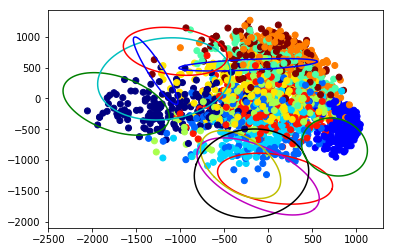

In [7]:
ndata = 2000
# randomly pick a subset of data
ndim = 2

transform2D = transform[:,:ndim]
selection = np.random.randint(len(transform2D), size=ndata)
data = transform2D[selection]
colors = train_labels[selection]
ngmm = 10

# get information of range on each dimension
dataRange = []
for i in range(data.shape[1]):
    dataRange.append({'MIN': min(data[:,i]), 'MAX': max(data[:,i])})
    
# randomly initialize Gaussian mixture model
mu    = randinitMean(ngmm, dataRange)
sigma = randinitCovarianceND(ngmm, ndim)
gmm   = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

gmmplot(data, gmm, colors)

As we can see, the initial clusters are completely random and do not do a good job of capturing the dataset.  For that reason, we will interatively apply the EM algorithm, in the same fashion as Exercise 1 and 2.

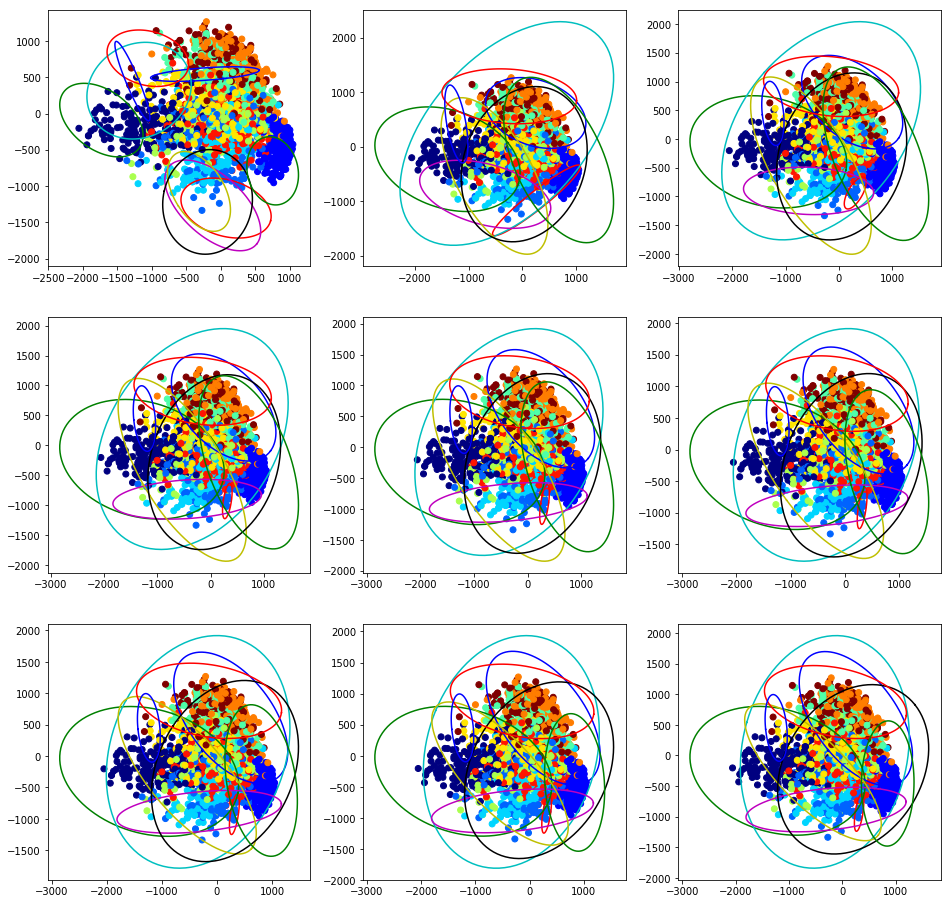

In [8]:
gmmcp = copy.deepcopy(gmm)

if ndim == 2:
    # create figure
    plt.figure(figsize=(16, 16))
# improve model with EM-Algorithm
for i in range(8):
    if ndim == 2:
        # plot current status
        plt.subplot(331 + i)
        gmmplot(data, gmmcp, colors)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization(posterior, data, gmmcp)
        #gmmcp[:]["covariance"] = 0.01 * np.eye(gmmcp[0]["covariance"].shape[0]) + gmmcp[:]["covariance"]
if ndim == 2:
    # plot final status
    plt.subplot(339)
    gmmplot(data,gmmcp, colors)

As we can see the EM algorithm does a decent job of identify clusters.  For instance, the black cluster is defined by the green cluster fairly well, and the red cluster does a good job of holding the orange points.  However, the cyan cluster, for instance, does a poor job of classifying the dataset, and captures the whole thing.  

For that reason, I want to explore the ability to run the EM algorithm in 3 dimensional space.

Using simple modifications of `plotGaussianModel2D` and `gmmplot`, we can plot the data points and the respective covriances with ellipsoids.

In [9]:
def plotGaussianModel3D(mu, sigma, ax, pltopt='k'):
    # your ellispsoid and center in matrix form
    A = sigma
    center = mu

    # find the rotation matrix and radii of the axes
    U, s, rotation = linalg.svd(A)
    radii = 1.0/np.sqrt(s) * 100

    # now carry on with EOL's answer
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center

    # plot
    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color=pltopt, alpha=0.2)
    

def gmmplot_3D(data, gmm, colors):
    # plot data points
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], c=colors, cmap=plt.cm.get_cmap('jet', 10), alpha=0.2)
    # plot Gaussian model
    for index, model in enumerate(gmm):
        plotGaussianModel3D(model['mean'], model['covariance'], ax, colorPicker(index))
    #plt.show()

In [ ]:
ndata = 2000
# randomly pick a subset of data
ndim = 3

transform2D = transform[:,:ndim]
selection = np.random.randint(len(transform2D), size=ndata)
data = transform2D[selection]
colors = train_labels[selection]
ngmm = 10

# get information of range on each dimension
dataRange = []
for i in range(data.shape[1]):
    dataRange.append({'MIN': min(data[:,i]), 'MAX': max(data[:,i])})
    
# randomly initialize Gaussian mixture model
mu    = randinitMean(ngmm, dataRange)
sigma = randinitCovarianceND(ngmm, ndim)
gmm   = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

The algorithm works exactly as the two dimension EM implementation.  However, due to issues I had with graphing, I had to plot each plot seperately.

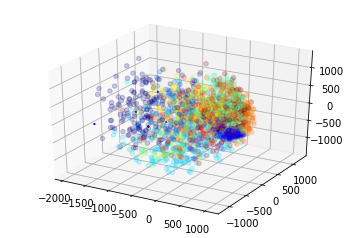

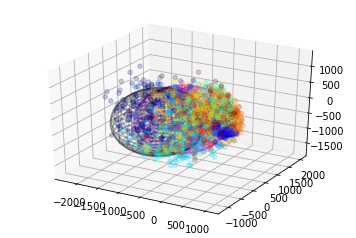

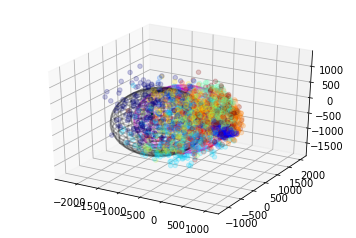

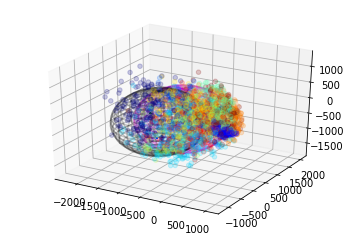

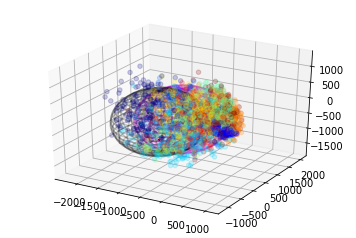

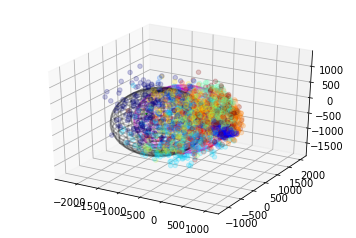

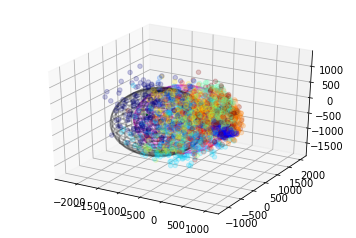

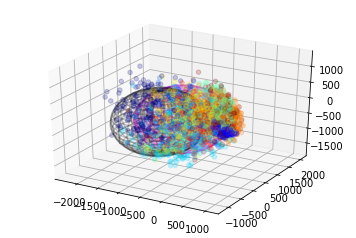

In [ ]:
gmmcp = copy.deepcopy(gmm)

for i in range(8):
    if ndim == 3:
        # plot current status
        gmmplot_3D(data, gmmcp, colors)
        plt.show()
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization(posterior, data, gmmcp)
        #gmmcp[:]["covariance"] = 0.01 * np.eye(gmmcp[0]["covariance"].shape[0]) + gmmcp[:]["covariance"]

### Conclusion

As with the 2D implentation, initial cluster movement occurs within the first step.  Unfortunately, it is hard to visualize the algorithms performance due to the amount of data being represented at once.  In addition, the clusters where generally **very** small, and required that I scale them.  However, it is very cool to see that they still capture the data in a more accurate way, indicating that higher dimensionality classification may be more ideal.